# Import necessary libraries and modules

In [1]:
!pip install xgboost
!pip install squarify
!pip install scikit-learn==0.24.2
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from wordcloud import WordCloud
from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split

import imblearn
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam
# outdated: from keras.preprocessing import sequence 
from keras.utils.data_utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

import squarify
from sklearn.metrics import f1_score

/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Assembling the Dataset 

In [3]:
df = pd.read_csv('mbti_1.csv')
#df = pd.read_csv('mbti_1.csv', index_col=False)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# count data for each personality type 
df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [5]:
def clean_data(x):
    data_length=[]
    wnl=WordNetLemmatizer()
    cleaned_text=[]
    stop_words = set(stopwords.words('english')) # Load stop words
    mbti_types = [ "ISTJ", "ESFJ", "ISTJ","ISFP",
                  "ESTJ", "ESFP", "ENFP","ISTP",
                  "INFP", "ESTP", "INTP", "ENTP", 
                  "ENFJ", "INTJ", "ENTJ", "INFJ" ]
    mbti_types = [t.lower() for t in mbti_types]
    
    for sent in df.posts:
        
        # Case Standardisation
        sent=sent.lower()
        
        # Remove URLs
        # source: Gabriel Giraldo-Wingler https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
        sent=re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*',' ',sent)
        
        # Remove punctuations
        sent=re.sub('[^0-9a-z]',' ',sent)
        
        # Remove stop words
        sent = " ".join([word for word in sent.split() if word not in stop_words]) 
        
        for t in mbti_types:
            sent = re.sub(t, '', sent)
            
        # Lemmatize
        sent = wnl.lemmatize(sent) 
        
        data_length.append(len(sent.split())) #Split data, measure length of new filtered data
        
        cleaned_text.append(sent)
        
    return cleaned_text,data_length

In [6]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [7]:
df_clean = df
df_clean.posts,df_clean_length=clean_data(df)
df_clean

,type,posts
0,INFJ,jpg moments sportscenter top ten plays prank...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear enjoyed conversation day esoteric gabbin...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else html post...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


#### After cleaning data

In [8]:
df_clean.posts[0]

'jpg   moments sportscenter top ten plays pranks life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello 7 sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth 84389 84390 jpg jpg welcome stuff jpg game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video games growing current favorite video games cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always aroun

## Baseline

A baseline model serves as a starting point for comparison in machine learning tasks, representing a simple or default approach to establish a performance benchmark.

As there are a total of 16 distinct labels in our dataset, the percentage of accuracy is 1/16 = 0.0625 or 6.25%.
We will use this value as our baseline to aim to develop a model that produces an accuracy of greater than 0.0625 in order to achieve statistical power.

### 1. Split data into train and test sets
The dataset is divided into training and testing sets in a 80:20 ratio. The training set is used for training the model and the testing set is used as a collection of data points that will help to assess the performance of the model in generalising new, unseen data

In [9]:
X = df['posts']
y = df['type']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df_clean['posts'],df_clean['type'], 
                                         test_size=0.2,
                                         random_state=0, 
                                         stratify= df.type)

### 2. TF-IDF Vectorization 
This is needed to convert text data into numerical vectors based on a previously trained vectorization model (such as TF-IDF or CountVectorizer). This transformation allows text data to be used as input for machine learning algorithms that require numerical features.

In [10]:
# calculates the term frequency-inverse document frequency weights for each word in the data 

#top 5000 most frequent words as features
tfidf = TfidfVectorizer(max_features=5000, 
                        tokenizer = Lemmatizer(), #class 
                        stop_words='english')

tfidf.fit(X_train_base)
# fit TfidfVectorizer on X_train to transform into TF-IDF matrix  
# contains the TF-IDF transformed training data.
X_train_vec= tfidf.fit_transform(X_train_base).toarray() # convert it to dense array using .toarray(). 

# fit TfidfVectorizer on X_test to transform into TF-IDF matrix
X_test_vec= tfidf.transform(X_test_base).toarray()

/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


In [11]:
X_train_vec

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05816291,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 3. Label Encoding 
We need to convert categorical data into numerical labels before they can be fitted into our machine learning models. Each category is assigned a unique integer.

In [12]:
# create an instance of label encoder 
labelencoder= LabelEncoder()

# train encoder based on mbti types
y_train_enc=labelencoder.fit_transform(y_train_base)
y_test_enc=labelencoder.fit_transform(y_test_base)
print("Classes:\n", labelencoder.classes_)

Classes:
 ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [13]:
y_train_enc

array([15,  8,  9, ...,  1,  9,  8])

In [14]:
y_test_enc

array([11,  3, 11, ...,  1,  9,  8])

### 4. Train and Evaluate Naive Bayes performance

In [15]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc 
def train_model(model):
    model.fit(X_train_vec, y_train_enc)
    y_pred_base = model.predict(X_test_vec)
    y_prob_base = model.predict_proba(X_test_vec)
    
    print(classification_report(y_test_enc, y_pred_base))
    
    sns.set_context('notebook', font_scale=1.3)
    fig, ax=plt.subplots(1,2, figsize=(25,8))
    
    # plot confusion matrix 
    ax1= plot_confusion_matrix(y_test_enc, y_pred_base, ax=ax[0], cmap='YlGnBu')
    
    # plot ROC curve
    ax2= plot_roc(y_test_enc, y_prob_base, ax=ax[1], 
                  plot_macro=False, plot_micro=False, cmap='summer')
    
    

/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suhyun/op

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.00      0.00      0.00       135
           2       0.00      0.00      0.00        46
           3       0.17      0.01      0.01       137
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        18
           8       0.30      0.28      0.29       294
           9       0.28      0.87      0.42       366
          10       0.46      0.10      0.16       218
          11       0.41      0.42      0.41       261
          12       0.00      0.00      0.00        33
          13       0.00      0.00      0.00        54
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00        67

    accuracy                           0.31      1735
   macro avg       0.10   

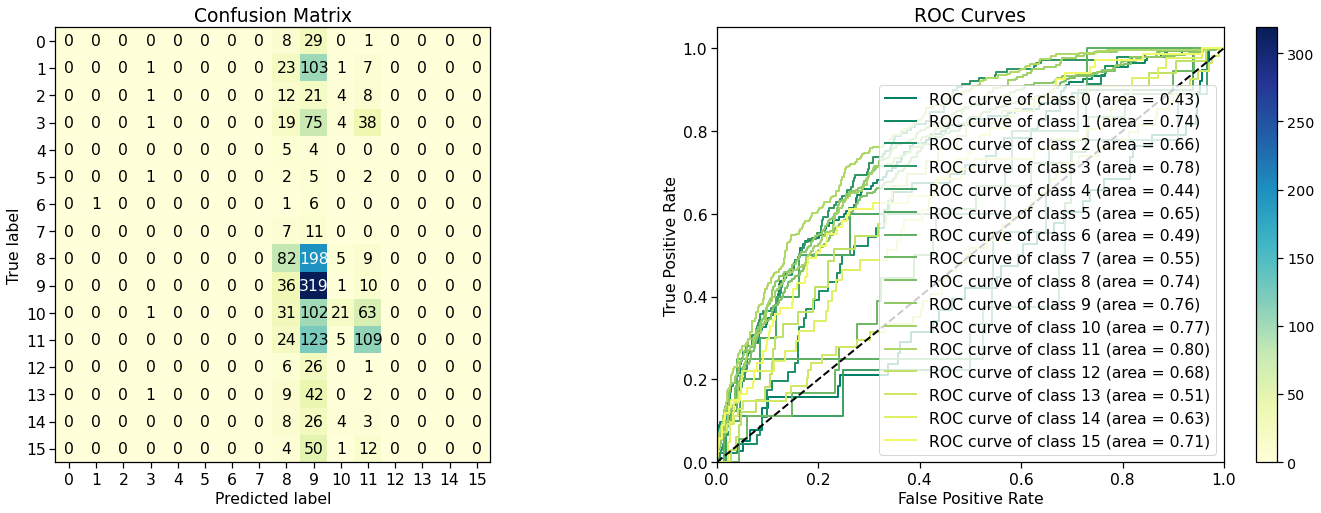

In [16]:
# Multinomial Naive Bayes classifier
nb = MultinomialNB()
train_model(nb)

The Naive Bayes model achieved an accuracy of 31%. This is almost 3 times higher than the LSTM and GRU models. 
However, this is expected as the training time for the deep learning models were much shorter. 